In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
from wordcloud import WordCloud, STOPWORDS


import warnings
warnings.filterwarnings('ignore')

In [2]:
txt_kaggle = pd.read_csv('Data/Emotion_final.csv')
txt_dataworld = pd.read_csv('Data/text_emotion.csv', usecols= ['content','sentiment'])

### Kaggle

In [3]:
print(txt_kaggle.head())

                                                Text  Emotion
0                            i didnt feel humiliated  sadness
1  i can go from feeling so hopeless to so damned...  sadness
2   im grabbing a minute to post i feel greedy wrong    anger
3  i am ever feeling nostalgic about the fireplac...     love
4                               i am feeling grouchy    anger


In [4]:
txt_kaggle.shape

(21459, 2)

In [5]:
pd.DataFrame(txt_kaggle.Emotion.value_counts())

,Emotion
happy,7029
sadness,6265
anger,2993
fear,2652
love,1641
surprise,879


### Data.world

In [6]:
txt_dataworld = txt_dataworld[['content','sentiment']]

Rename Columns

In [7]:
txt_dataworld.rename(columns={'content':'Text',
                            'sentiment':'Emotion'}, inplace=True)

In [8]:
print(txt_dataworld.head())

                                                Text     Emotion
0  @tiffanylue i know  i was listenin to bad habi...       empty
1  Layin n bed with a headache  ughhhh...waitin o...     sadness
2                Funeral ceremony...gloomy friday...     sadness
3               wants to hang out with friends SOON!  enthusiasm
4  @dannycastillo We want to trade with someone w...     neutral


In [9]:
txt_dataworld.shape

(40000, 2)

In [10]:
pd.DataFrame(txt_dataworld.Emotion.value_counts())

,Emotion
neutral,8638
worry,8459
happiness,5209
sadness,5165
love,3842
surprise,2187
fun,1776
relief,1526
hate,1323
empty,827


### Concatenate

In [11]:
data = pd.concat([txt_kaggle, txt_dataworld])

In [12]:
data.shape

(61459, 2)

In [13]:
data.head()

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [14]:
data.Emotion.unique()

array(['sadness', 'anger', 'love', 'surprise', 'fear', 'happy', 'empty',
       'enthusiasm', 'neutral', 'worry', 'fun', 'hate', 'happiness',
       'boredom', 'relief'], dtype=object)

Replace value Happy to Happiness

In [15]:
data['Emotion'] = data.Emotion.apply(lambda x: "happiness" if x == "happy" else x)


In [16]:
pd.DataFrame(data.Emotion.value_counts())

,Emotion
happiness,12238
sadness,11430
neutral,8638
worry,8459
love,5483
anger,3103
surprise,3066
fear,2652
fun,1776
relief,1526


In [17]:
data.Text

0                                  i didnt feel humiliated
1        i can go from feeling so hopeless to so damned...
2         im grabbing a minute to post i feel greedy wrong
3        i am ever feeling nostalgic about the fireplac...
4                                     i am feeling grouchy
                               ...                        
39995                                     @JohnLloydTaylor
39996                       Happy Mothers Day  All my love
39997    Happy Mother's Day to all the mommies out ther...
39998    @niariley WASSUP BEAUTIFUL!!! FOLLOW ME!!  PEE...
39999    @mopedronin bullet train from tokyo    the gf ...
Name: Text, Length: 61459, dtype: object

### Lower case

In [18]:
data['Text'] = data['Text'].apply(lambda x: " ".join(x.lower() for x in x.split()))

In [19]:
import re

#remove punctuation
data['Text'] = data['Text'].map(lambda x: re.sub('[,\.!?]()@_','',x))
data['Text'] = data['Text'].map(lambda x: re.sub('_','',x))
data['Text'] = data['Text'].map(lambda x: re.sub('-','',x))
data['Text'] = data['Text'].map(lambda x: re.sub('@','',x))
data['Text'] = data['Text'].map(lambda x: re.sub('&','',x))

data['Text'] = data['Text'].replace("???ï¿½ï¿½  ???","")
data['Text'] = data['Text'].replace("??????? ????????? ??","")
data['Text'] = data['Text'].replace("ï¿½8","")




In [20]:
# STOPWORDS

### Exploratory Data

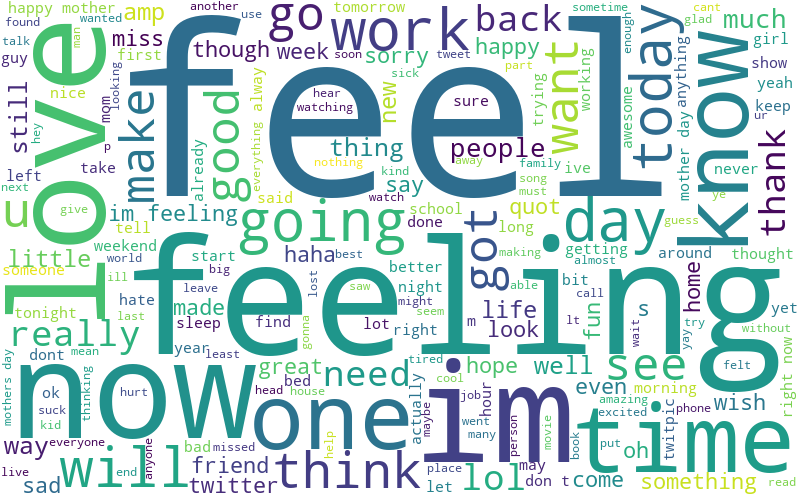

In [21]:
# import wordcloud
from wordcloud import WordCloud

# concat column Text and ingredient
content = ','.join(list(data['Text'].values))

#Create wordcloud object
wordcloud = WordCloud(background_color = 'white',
                    width=800,
                    height=500,
                    max_words = 200,
                    contour_width = 3,
                    contour_color = 'steelblue')

# Generate word cloud
wordcloud.generate(content)

# visualize wordcloud
wordcloud.to_image()



### Bigrams

In [22]:
from gensim.models.phrases import Phrases, Phraser

In [23]:
sent = [row.split() for row in data['Text']]

In [24]:
phrases = Phrases(sent, min_count=30, progress_per=10000)

In [25]:
bigram = Phraser(phrases)

In [26]:
sentences = bigram[sent]

### Most Frequent Words:

In [27]:
from collections import defaultdict  # For word frequency

In [28]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

83595

In [29]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['i', 'the', 'to', 'and', 'a', 'feel', 'my', 'of', 'that', 'in']

### Training the model

In [30]:
import multiprocessing

from gensim.models import Word2Vec

1. Word2Vec(): In this first step, I set up the parameters of the model one-by-one. I do not supply the parameter sentences, and therefore leave the model uninitialized, purposefully.

2. build_vocab(): Here it builds the vocabulary from a sequence of sentences and thus initialized the model. With the loggings, I can follow the progress and even more important, the effect of min_count and sample on the word corpus. I noticed that these two parameters, and in particular sample,
 have a great influence over the performance of a model. Displaying both
 allows for a more accurate and an easier management of their influence.

3. train():Finally, trains the model.
The loggings here are mainly useful for monitoring, making sure that no threads are executed instantaneously.


In [31]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer

### The parameters:

min_count = int - Ignores all words with total absolute frequency lower than this - (2, 100) 

window = int - The maximum distance between the current and predicted word within a sentence. E.g. window words on the left and window words on the left of our target - (2, 10)

size = int - Dimensionality of the feature vectors. - (50, 300)

sample = float - The threshold for configuring which higher-frequency words are randomly down sampled. Highly influencial. - (0, 1e-5)

alpha = float - The initial learning rate - (0.01, 0.05)

min_alpha = float - Learning rate will linearly drop to min_alpha as training progresses. To set it: alpha - (min_alpha * epochs) ~ 0.00

negative = int - If &gt; 0, negative sampling will be used, the int for negative specifies how many "noise words" should be drown. If set to 0, no negative sampling is used. - (5, 

20)workers = int - Use these many worker threads to train the model (=faster training with multicore machines)

In [32]:
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=200,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

### Building the Vocabulary Table:

In [33]:
from time import time 

t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))



Time to build vocab: 0.05 mins


### Training of the model:

In [34]:
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 1.36 mins


In [35]:
w2v_model.init_sims(replace=True)

### Exploring the model

In [36]:
w2v_model.wv.most_similar(positive=["good"])

[('bad', 0.629091739654541),
 ('great', 0.6233173608779907),
 ('nice', 0.5553022623062134),
 ('a_great', 0.5485920310020447),
 ('great!', 0.5346634387969971),
 ('an_awesome', 0.5009121894836426),
 ('brilliant', 0.49871769547462463),
 ('exciting', 0.496090292930603),
 ('fun', 0.49561136960983276),
 ('wonderful', 0.48691117763519287)]

In [37]:
w2v_model.wv.most_similar(negative=["good"])

[('unable', 0.22110110521316528),
 ('easily', 0.21987047791481018),
 ('am_feeling', 0.19117489457130432),
 ('comes', 0.19075483083724976),
 ('im_feeling', 0.18322636187076569),
 ('sit', 0.18312501907348633),
 ('every_time', 0.181429922580719),
 ('bit', 0.18107296526432037),
 ('couldn_t', 0.17814873158931732),
 ('skills', 0.17768895626068115)]

In [38]:
w2v_model.wv.most_similar(positive=["sadness"])

[('despair', 0.8607311248779297),
 ('anguish', 0.8522367477416992),
 ('anger', 0.8325575590133667),
 ('tears', 0.7934786081314087),
 ('hearts', 0.7862156629562378),
 ('sorrow', 0.7514374852180481),
 ('grief', 0.7357687950134277),
 ('relief', 0.7286398410797119),
 ('understanding', 0.7257038950920105),
 ('aware', 0.7206414937973022)]

In [39]:
w2v_model.wv.most_similar(positive=["anger"])

[('despair', 0.8921095728874207),
 ('anguish', 0.8545982837677002),
 ('sadness', 0.8325575590133667),
 ('annoyance', 0.8190691471099854),
 ('repressed', 0.7855772972106934),
 ('grief', 0.7835830450057983),
 ('sorrow', 0.7746943235397339),
 ('fear', 0.7712992429733276),
 ('exasperation', 0.766464114189148),
 ('caused', 0.7651234269142151)]

In [40]:
w2v_model.wv.most_similar(positive=["love"])

[('loved', 0.5936970114707947),
 ('loves', 0.5898974537849426),
 ('miss', 0.5832028985023499),
 ('xo', 0.5595754384994507),
 ('bless', 0.5517958402633667),
 ('ya!', 0.5496351718902588),
 ('loving', 0.5430614352226257),
 ('luv', 0.5428018569946289),
 ('congrats', 0.5386812686920166),
 ('appreciate', 0.5344910025596619)]

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=8eda8dfb-8785-4fbe-bb1b-3e03c30b05a5' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>